In [1]:
! pip install geopandas
! pip install pandas
! pip install pygeos
! pip install boto
! pip install s3fs
! pip install shapely
! pip install gcsfs
!pip install contextily
!pip install matplotlib-scalebar
!pip install sklearn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gzip
import time
from itertools import groupby
import geopandas as gpd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_404558/1227132047.py:18: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).

In [2]:
cordon_zones = ['060750615006',
'060750615005',
'060750615004',
'060750615003',
'060750615002',
'060750615001',
'060750611003',
'060750611002',
'060750611001',
'060750607003',
'060750607002',
'060750607001',
'060750202001',
'060750201004',
'060750201003',
'060750201002',
'060750201001',
'060750180002',
'060750180001',
'060750178022',
'060750178021',
'060750178012',
'060750178011',
'060750177002',
'060750177001',
'060750176015',
'060750176014',
'060750176013',
'060750176012',
'060750176011',
'060750168023',
'060750168021',
'060750162003',
'060750162002',
'060750162001',
'060750125022',
'060750125021',
'060750125012',
'060750125011',
'060750124023',
'060750124022',
'060750124021',
'060750124012',
'060750124011',
'060750123022',
'060750123021',
'060750123012',
'060750123011',
'060750122021',
'060750122012',
'060750122011',
'060750121002',
'060750121001',
'060750120002',
'060750120001',
'060750119022',
'060750119021',
'060750119012',
'060750119011',
'060750118001',
'060750117002',
'060750117001',
'060750113002',
'060750113001',
'060750112003',
'060750112002',
'060750112001',
'060750111003',
'060750111002',
'060750111001',
'060750110003',
'060750110002',
'060750110001',
'060750109003',
'060750109002',
'060750109001',
'060750108003',
'060750108002',
'060750108001',
'060750107004',
'060750107003',
'060750107002',
'060750107001',
'060750106003',
'060750106002',
'060750106001',
'060750105002',
'060750105001',
'060750104004',
'060750104003',
'060750104002',
'060750104001',
'060750103003',
'060750103002',
'060750103001',
'060750102003',
'060750102002',
'060750102001',
'060750101002',
'060750101001']

In [3]:
def addGeometryIdToDataFrame(df, gdf, xcol, ycol, idColumn="geometry", df_geom='epsg:32610'): 
    gdf.crs = {'init': 'epsg:4326'}
    gdf_data = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[xcol], df[ycol]))
    gdf_data.crs = {'init': df_geom}
    joined = gpd.sjoin(gdf_data.to_crs('epsg:26910'), gdf.to_crs('epsg:26910'))
    gdf_data = gdf_data.merge(joined['blkgrpid'], left_index=True, right_index=True, how="left")
    gdf_data.rename(columns={'blkgrpid': idColumn}, inplace=True)
    df = pd.DataFrame(gdf_data.drop(columns='geometry'))
    # df.drop(columns=[xcol, ycol], inplace=True)
    
    return df.loc[~df.index.duplicated(keep='first'), :]

In [4]:
def plot_map(scenario_name, dpi, baseline, cordon, BGs, vmaxes, vmines):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    dfs = [baseline, cordon]
    titles = ["Number_car_trips_arriving", "Number_car_trips_arriving"]
    titles_ = ["%s"%(scenario_name), "%s"%(scenario_name)]

    cmap = "viridis"

    gdf = BGs
    gdf = gdf.to_crs('EPSG:3857')

    for i, (df, title, title_, vmax, vmin)  in enumerate(zip(dfs, titles, titles_, vmaxes, vmines)):


        # Join the two dataframes on a common attribute
        merged = gdf.merge(df, on="blkgrpid")

        # Plot the merged data using the values from the pandas DataFrame
        merged.plot(column=title, cmap=cmap, ax=axes[i], alpha=0.9, norm=plt.Normalize(vmin=vmin, vmax=vmax))

        # Add a legend
        # vmin, vmax = merged[title].min(), merged[title].max()
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm._A = []
        ctx.add_basemap(axes[i], source=ctx.providers.Stamen.TonerLite, alpha=0.8, attribution_size=4)
        axes[i].text(0.05, 0.9, "N\n↑", ha="center", va="center", transform=axes[i].transAxes, fontsize=14)

        scalebar = ScaleBar(3, "m", length_fraction=0.2, height_fraction=0.02, frameon=False, location='lower right')
        axes[i].add_artist(scalebar)

        # Create a colorbar axis
        cax = fig.add_axes([0.12 + i*0.275, 0.07, 0.235, 0.02])

        # Add a colorbar to the plot using the color map and normalization instance
        cb = fig.colorbar(sm, cax=cax, orientation='horizontal')
        cb.ax.tick_params(labelsize=8)
        tick_fmt = ticker.FormatStrFormatter('%.2f')
        cb.ax.xaxis.set_major_formatter(tick_fmt)
        axes[i].set_xticklabels([])
        axes[i].set_yticklabels([])
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_title(title_)

    plt.savefig("outputs/%s.png"%(scenario_name), dpi=dpi)
    
    return True

In [5]:

def process(plans, persons, households, BGs):
    person_to_hs = dict(zip(persons.personId, persons.householdId))
    hs_to_income = dict(zip(households.householdId, households.incomeValue))
    person_to_income = {key: hs_to_income[person_to_hs[key]] for key in person_to_hs}

    plans = plans[plans['planSelected']==True]
    plans['income'] = plans['personId'].map(person_to_income)
    av_income =  plans['income'].mean()
    
    
    plans_orig_to_des = plans.sort_values(by=['personId','planElementIndex'], ascending=True)
    
    xs = []
    ys = []
    starts = []
    for x, y, start in zip(plans_orig_to_des['activityLocationX'], plans_orig_to_des['activityLocationY'],plans_orig_to_des['activityEndTime']):
        if x > -999999999999999999:
            xs.append(x)
            ys.append(y)
            starts.append(0)
            current_start = start
            current_x = x
            current_y = y
        else:
            xs.append(current_x)
            ys.append(current_y)           
            starts.append(current_start)
            
    plans_orig_to_des['tripOriginX'] = xs
    plans_orig_to_des['tripOriginY'] = ys
    plans_orig_to_des['legDepartureTime'] = starts
    
    plans_orig_to_des = plans_orig_to_des.sort_values(by=['personId','planElementIndex'], ascending=False)
    
    xs = []
    ys = []
    for x, y in zip(plans_orig_to_des['activityLocationX'], plans_orig_to_des['activityLocationY']):
        if x > -999999999999999999:
            xs.append(x)
            ys.append(y)
            current_x = x
            current_y = y
        else:
            xs.append(current_x)
            ys.append(current_y)
    plans_orig_to_des['tripDestX'] = xs
    plans_orig_to_des['tripDestY'] = ys
    
    plans_orig_to_des = plans_orig_to_des.sort_values(by=['personId','planElementIndex'], ascending=True)
    
    plans_dest = plans.sort_values(by=['personId','planElementIndex'], ascending=True)

    starts = []
    
    for x, start in zip(plans_dest['activityLocationX'],plans_dest['activityEndTime']):
        if x > -999999999999999999:
            starts.append(0)
            current_start = start
        else:
            starts.append(current_start)

    plans_dest['legDepartureTime'] = starts

    
    plans_dest = plans_dest.sort_values(by=['personId','planElementIndex'], ascending=False)
    xs = []
    ys = []
    for x, y in zip(plans_dest['activityLocationX'], plans_dest['activityLocationY']):
        if x > -999999999999999999:
            xs.append(x)
            ys.append(y)
            current_x = x
            current_y = y
        else:
            xs.append(current_x)
            ys.append(current_y)
    plans_dest['activityLocationX'] = xs
    plans_dest['activityLocationY'] = ys
    
    plans_dest = plans_dest.sort_values(by=['personId','planElementIndex'], ascending=True)
    
    plans_orig = plans.sort_values(by=['personId','planElementIndex'], ascending=True)
    xs = []
    ys = []
    starts = []
    for x, y, start in zip(plans_orig['activityLocationX'], plans_orig['activityLocationY'],plans_orig['activityEndTime']):
        if x > -999999999999999999:
            xs.append(x)
            ys.append(y)
            starts.append(0)
            current_start = start
            current_x = x
            current_y = y
        else:
            xs.append(current_x)
            ys.append(current_y)           
            starts.append(current_start)
            
    plans_orig['activityLocationX'] = xs
    plans_orig['activityLocationY'] = ys
    plans_orig['legDepartureTime'] = starts
    
    print('plans_dest',plans_dest)
    print('plans_orig',plans_orig)
    print('plans_orig_to_des',plans_orig_to_des)
    
    print(len(plans_orig_to_des[plans_orig_to_des['legMode'].isin(['car', 'car_hov2', 'car_hov3'])]))
    plans_car = plans_orig_to_des[(plans_orig_to_des['legMode'].isin(['car']))&(plans_orig_to_des['legDepartureTime']>0)]
    plans_car_pool = plans_orig_to_des[(plans_orig_to_des['legMode'].isin(['car_hov2', 'car_hov3']))&(plans_orig_to_des['legDepartureTime']>0)]
    plans_rh = plans_orig_to_des[(plans_orig_to_des['legMode'].isin(['ride_hail']))&(plans_orig_to_des['legDepartureTime']>0)]
    plans_rh_pool = plans_orig_to_des[(plans_orig_to_des['legMode'].isin(['ride_hail_pooled']))&(plans_orig_to_des['legDepartureTime']>0)]
    print(len(plans_car))
    plans_rh_dest = plans_dest[(plans_dest['legMode'] == 'ride_hail')|(plans_dest['legMode'] == 'ride_hail_pooled')]
    plans_rh_orig = plans_orig[(plans_orig['legMode'] == 'ride_hail')|(plans_orig['legMode'] == 'ride_hail_pooled')]  
    plans_car_peak =     plans_car[(((plans_car['legDepartureTime'] >=6*3600)&(plans_car['legDepartureTime'] <=10*3600))|((plans_car['legDepartureTime'] >=15*3600)&(plans_car['legDepartureTime'] <=19*3600)))]
    plans_rh_dest_peak = plans_rh_dest[(((plans_rh_dest['legDepartureTime'] >=6*3600)&(plans_rh_dest['legDepartureTime'] <=10*3600))|((plans_rh_dest['legDepartureTime'] >=15*3600)&(plans_rh_dest['legDepartureTime'] <=19*3600)))]
    plans_rh_orig_peak = plans_rh_orig[(((plans_rh_orig['legDepartureTime'] >=6*3600)&(plans_rh_orig['legDepartureTime'] <=10*3600))|((plans_rh_orig['legDepartureTime'] >=15*3600)&(plans_rh_orig['legDepartureTime'] <=19*3600)))]
    plans_car_low_income  = plans_car[plans_car['income']<av_income]
    plans_rh_dest_low_income =plans_rh_dest[plans_rh_dest['income']<av_income]
    plans_rh_orig_low_income = plans_rh_orig[plans_rh_orig['income']<av_income]
            
    plans_car = addGeometryIdToDataFrame(plans_car, BGs, 'tripOriginX', 'tripOriginY', 'ZIPo')
    plans_car = addGeometryIdToDataFrame(plans_car, BGs, 'tripDestX', 'tripDestY', 'ZIP')
    plans_car_pool = addGeometryIdToDataFrame(plans_car_pool, BGs, 'tripOriginX', 'tripOriginY', 'ZIPo')
    plans_car_pool = addGeometryIdToDataFrame(plans_car_pool, BGs, 'tripDestX', 'tripDestY', 'ZIP')
    plans_rh = addGeometryIdToDataFrame(plans_rh, BGs, 'tripOriginX', 'tripOriginY', 'ZIPo')
    plans_rh = addGeometryIdToDataFrame(plans_rh, BGs, 'tripDestX', 'tripDestY', 'ZIP')
    plans_rh_pool = addGeometryIdToDataFrame(plans_rh_pool, BGs, 'tripOriginX', 'tripOriginY', 'ZIPo')
    plans_rh_pool = addGeometryIdToDataFrame(plans_rh_pool, BGs, 'tripDestX', 'tripDestY', 'ZIP')
    plans_rh_dest = addGeometryIdToDataFrame(plans_rh_dest, BGs, 'activityLocationX', 'activityLocationY', 'ZIP')
    plans_rh_orig = addGeometryIdToDataFrame(plans_rh_orig, BGs, 'activityLocationX', 'activityLocationY', 'ZIP')
    plans_car_peak = addGeometryIdToDataFrame(plans_car_peak, BGs, 'tripOriginX', 'tripOriginY', 'ZIPo')
    plans_car_peak = addGeometryIdToDataFrame(plans_car_peak, BGs, 'tripDestX', 'tripDestY', 'ZIP')
    plans_rh_dest_peak = addGeometryIdToDataFrame(plans_rh_dest_peak, BGs, 'activityLocationX', 'activityLocationY', 'ZIP')
    plans_rh_orig_peak = addGeometryIdToDataFrame(plans_rh_orig_peak, BGs, 'activityLocationX', 'activityLocationY', 'ZIP')
    plans_car_low_income  = addGeometryIdToDataFrame(plans_car_low_income, BGs, 'tripOriginX', 'tripOriginY', 'ZIPo')
    plans_car_low_income  = addGeometryIdToDataFrame(plans_car_low_income, BGs, 'tripDestX', 'tripDestY', 'ZIP')
    plans_rh_dest_low_income = addGeometryIdToDataFrame(plans_rh_dest_low_income, BGs, 'activityLocationX', 'activityLocationY', 'ZIP')
    plans_rh_orig_low_income = addGeometryIdToDataFrame(plans_rh_orig_low_income, BGs, 'activityLocationX', 'activityLocationY', 'ZIP')
    
    plans_rhsolo_to_save = plans_rh
    plans_rhpool_to_save = plans_rh_pool
    plans_carpool_to_save = plans_car_pool[~plans_car_pool['ZIPo'].isin(cordon_zones)]
    plans_carsolo_to_save = plans_car[~plans_car['ZIPo'].isin(cordon_zones)]
    plans_car_peak = plans_car_peak[~plans_car_peak['ZIPo'].isin(cordon_zones)]
    plans_car_low_income = plans_car_low_income[~plans_car_low_income['ZIPo'].isin(cordon_zones)]
    
    plans_car = plans_carsolo_to_save.ZIP.value_counts().to_dict()
    plans_rh_dest = plans_rh_dest.ZIP.value_counts().to_dict()
    plans_rh_orig = plans_rh_orig.ZIP.value_counts().to_dict()
    plans_car_peak = plans_car_peak.ZIP.value_counts().to_dict()
    plans_rh_dest_peak = plans_rh_dest_peak.ZIP.value_counts().to_dict()
    plans_rh_orig_peak = plans_rh_orig_peak.ZIP.value_counts().to_dict()
    plans_car_low_income  = plans_car_low_income.ZIP.value_counts().to_dict()
    plans_rh_dest_low_income = plans_rh_dest_low_income.ZIP.value_counts().to_dict()
    plans_rh_orig_low_income = plans_rh_orig_low_income.ZIP.value_counts().to_dict()

    plans_car = pd.DataFrame.from_dict(plans_car, orient='index', columns=['Number_car_trips_arriving'])
    plans_rh_dest = pd.DataFrame.from_dict(plans_rh_dest, orient='index', columns=['Number_rh_trips_arriving'])
    plans_rh_orig = pd.DataFrame.from_dict(plans_rh_orig, orient='index', columns=['Number_rh_trips_departing'])
    plans_car.index.name = 'blkgrpid'
    plans_rh_dest.index.name = 'blkgrpid'
    plans_rh_orig.index.name = 'blkgrpid'
    plans_car_peak = pd.DataFrame.from_dict(plans_car_peak, orient='index', columns=['Number_car_trips_arriving'])
    plans_rh_dest_peak = pd.DataFrame.from_dict(plans_rh_dest_peak, orient='index', columns=['Number_rh_trips_arriving'])
    plans_rh_orig_peak = pd.DataFrame.from_dict(plans_rh_orig_peak, orient='index', columns=['Number_rh_trips_departing'])
    plans_car_peak.index.name = 'blkgrpid'
    plans_rh_dest_peak.index.name = 'blkgrpid'
    plans_rh_orig_peak.index.name = 'blkgrpid'
    plans_car_low_income = pd.DataFrame.from_dict(plans_car_low_income, orient='index', columns=['Number_car_trips_arriving'])
    plans_rh_dest_low_income = pd.DataFrame.from_dict(plans_rh_dest_low_income, orient='index', columns=['Number_rh_trips_arriving'])
    plans_rh_orig_low_income = pd.DataFrame.from_dict(plans_rh_orig_low_income, orient='index', columns=['Number_rh_trips_departing'])
    plans_car_low_income.index.name = 'blkgrpid'
    plans_rh_dest_low_income.index.name = 'blkgrpid'
    plans_rh_orig_low_income.index.name = 'blkgrpid'
    
    return plans_car, plans_rh_dest, plans_rh_orig, plans_car_peak, plans_rh_dest_peak, plans_rh_orig_peak, plans_car_low_income, plans_rh_dest_low_income, plans_rh_orig_low_income, plans_carsolo_to_save, plans_rhsolo_to_save, plans_carpool_to_save, plans_rhpool_to_save


In [6]:
#Read
print('Baseline')
plans_base =     pd.read_csv('gs://beam-core-outputs/sfbay-baseline-20230526/beam/year-2020-iteration-4/ITERS/it.0/0.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode', 'legDepartureTime', 'activityEndTime'])
print('Cordon')
#test2 10% ignore if not depart
# plans_cordon =     pd.read_csv('gs://beam-core-outputs/sfbay-cordon-test2-20230626/beam/year-2020-iteration-4/ITERS/it.0/0.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode', 'legDepartureTime', 'activityEndTime'])
#test3 10000 hs, read Table trips in the trips yaml
# plans_cordon =     pd.read_csv('gs://beam-core-outputs/sfbay-cordon-test3-20230627/beam/year-2018-iteration-4/ITERS/it.0/0.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode', 'legDepartureTime', 'activityEndTime'])
# test4 10000 hs, use the tour start and end
# plans_cordon =     pd.read_csv('gs://beam-core-outputs/sfbay-cordon-test4-20230627/beam/year-2020-iteration-4/ITERS/it.0/0.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode', 'legDepartureTime', 'activityEndTime'])
#test3 10%pop, read Table trips in the trips yaml
# plans_cordon =     pd.read_csv('gs://beam-core-outputs/sfbay-cordon-test3_1-20230629/beam/year-2018-iteration-4/ITERS/it.0/0.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode', 'legDepartureTime', 'activityEndTime'])
# test4 10%pop, use the tour start and end
# plans_cordon =     pd.read_csv('gs://beam-core-outputs/sfbay-cordon-test4_1-20230629/beam/year-2020-iteration-4/ITERS/it.0/0.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode', 'legDepartureTime', 'activityEndTime'])
# test5 275000 hs, il 3, aggiungi people starting from outside and going inside
# plans_cordon =     pd.read_csv('gs://beam-core-outputs/sfbay-cordon-test5-20230630/beam/year-2018-iteration-4/ITERS/it.0/0.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode', 'legDepartureTime', 'activityEndTime'])
# test6 10%pop, il 3, aggiungi people starting from outside and going inside
# plans_cordon =     pd.read_csv('gs://beam-core-outputs/sfbay-cordon-test6-20230630/beam/year-2019-iteration-4/ITERS/it.0/0.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode', 'legDepartureTime', 'activityEndTime'])
# test 6.1 add the # on free tool avoid
# plans_cordon =     pd.read_csv('gs://beam-core-outputs/sfbay-cordon-test6-20230701/beam/year-2018-iteration-4/ITERS/it.0/0.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode', 'legDepartureTime', 'activityEndTime'])
# test 7 is the 6.1. without beam toll cost in the routing
# plans_cordon =     pd.read_csv('gs://beam-core-outputs/sfbay-cordon-test7-20230701/beam/year-2018-iteration-4/ITERS/it.0/0.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode', 'legDepartureTime', 'activityEndTime'])
# test 8 is the 6.1. without beam toll cost in the routing - add <=9
plans_cordon =     pd.read_csv('gs://beam-core-outputs/sfbay-cordon-MTA-20230703/beam/year-2020-iteration-4/ITERS/it.0/0.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode', 'legDepartureTime', 'activityEndTime'])
# test 9 is the 8, no beam cost
# plans_cordon =     pd.read_csv('gs://beam-core-outputs/sfbay-cordon-MTA-nobeamtoll-20230703/beam/year-2020-iteration-4/ITERS/it.0/0.plans.csv.gz', usecols = ['personId','planSelected','activityType', 'activityLocationX', 'activityLocationY', 'planElementIndex', 'legMode', 'legDepartureTime', 'activityEndTime'])

BGs = gpd.read_file('/vsicurl/https://github.com/LBNL-UCB-STI/beam-core-analysis/raw/main/Users/Zach/scenario/sfbay-blockgroups-2010/641aa0d4-ce5b-4a81-9c30-8790c4ab8cfb202047-1-wkkklf.j5ouj.shp')


Baseline
Cordon


In [7]:
persons_base = pd.read_csv('gs://beam-core-outputs/sfbay-baseline-20230526/beam/year-2020-iteration-4/population.csv.gz', usecols = ['householdId', 'personId'])
households_base = pd.read_csv('gs://beam-core-outputs/sfbay-baseline-20230526/beam/year-2020-iteration-4/households.csv.gz', usecols = ['householdId', 'incomeValue'])
persons_cordon = pd.read_csv('gs://beam-core-outputs/sfbay-cordon-MTA-20230703/beam/year-2020-iteration-4/population.csv.gz', usecols = ['householdId','personId'])
households_cordon = pd.read_csv('gs://beam-core-outputs/sfbay-cordon-MTA-20230703/beam/year-2020-iteration-4/households.csv.gz', usecols = ['householdId', 'incomeValue'])

In [8]:
distr_car_base, distr_rh_base_dest, distr_rh_base_orig, distr_car_base_peak, distr_rh_base_dest_peak, distr_rh_base_orig_peak, distr_car_base_low_income, distr_rh_base_dest_low_income, distr_rh_base_orig_low_income, plans_carsolo_to_save_base, plans_rhsolo_to_save_base, plans_carpool_to_save_base, plans_rhpool_to_save_base = process(plans_base, persons_base,  households_base,  BGs)
distr_car_cordon, distr_rh_cordon_dest,distr_rh_cordon_orig, distr_car_cordon_peak, distr_rh_cordon_dest_peak,distr_rh_cordon_orig_peak, distr_car_cordon_low_income, distr_rh_cordon_dest_low_income, distr_rh_cordon_orig_low_income, plans_carsolo_to_save_cordon, plans_rhsolo_to_save_cordon, plans_carpool_to_save_cordon, plans_rhpool_to_save_cordon = process(plans_cordon, persons_cordon, households_cordon,  BGs)



/tmp/ipykernel_404558/2069817970.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plans['income'] = plans['personId'].map(person_to_income)


plans_dest          personId  planSelected  planElementIndex activityType  \
7563273         4          True                 0         Home   
7563274         4          True                 1          NaN   
7563275         4          True                 2     othdiscr   
7563276         4          True                 3          NaN   
7563277         4          True                 4       social   
...           ...           ...               ...          ...   
2283162   6808834          True                 2         work   
2283163   6808834          True                 3          NaN   
2283164   6808834          True                 4       eatout   
2283165   6808834          True                 5          NaN   
2283166   6808834          True                 6         Home   

         activityLocationX  activityLocationY  activityEndTime legMode  \
7563273      567919.614977       4.189908e+06          55026.0     NaN   
7563274      566680.335629       4.183202e+06   

/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of 

plans_dest          personId  planSelected  planElementIndex activityType  \
7545080         4          True                 0         Home   
7545081         4          True                 1          NaN   
7545082         4          True                 2     othdiscr   
7545083         4          True                 3          NaN   
7545084         4          True                 4       social   
...           ...           ...               ...          ...   
2272185   6808834          True                 0         Home   
2272186   6808834          True                 1          NaN   
2272187   6808834          True                 2         work   
2272188   6808834          True                 3          NaN   
2272189   6808834          True                 4         Home   

         activityLocationX  activityLocationY  activityEndTime legMode  \
7545080      567919.614977       4.189908e+06          55353.6     NaN   
7545081      566119.984702       4.183143e+06   

/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of 

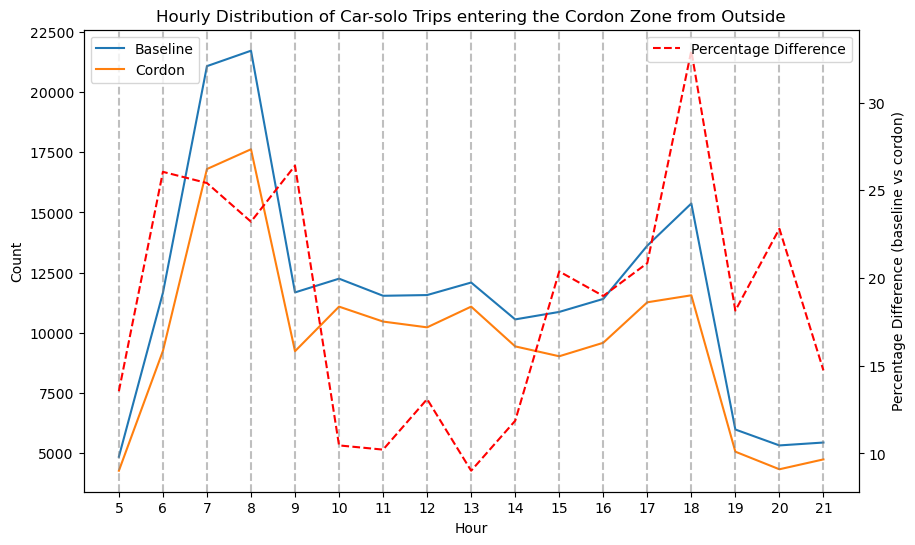

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = plans_carsolo_to_save_base
df2 = plans_carsolo_to_save_cordon

df1 = df1[~df1['ZIPo'].isin(cordon_zones)]
df1 = df1[df1['ZIP'].isin(cordon_zones)]
df2 = df2[~df2['ZIPo'].isin(cordon_zones)]
df2 = df2[df2['ZIP'].isin(cordon_zones)]

df1 = df1[df1['legDepartureTime']>=5*3600]
df2 = df2[df2['legDepartureTime']>=5*3600]

df1['legDepartureTime'] = pd.to_datetime(df1['legDepartureTime'], unit='s')
df1['hour'] = df1['legDepartureTime'].dt.hour
df1 = df1[df1['hour']>=5]
df1 = df1[df1['hour']<=21]
hourly_counts = df1['hour'].value_counts().sort_index() * 10

df2['legDepartureTime'] = pd.to_datetime(df2['legDepartureTime'], unit='s')
df2['hour'] = df2['legDepartureTime'].dt.hour
df2 = df2[df2['hour']>=5]
df2 = df2[df2['hour']<=21]
hourly_counts2 = df2['hour'].value_counts().sort_index() * 10

# Calculate percentage difference
percentage_diff = (hourly_counts - hourly_counts2) / hourly_counts2 * 100

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the hourly distribution from the first DataFrame (df1)
ax1.plot(hourly_counts.index, hourly_counts.values, label='Baseline')

# Plot the hourly distribution from the second DataFrame (df2)
ax1.plot(hourly_counts2.index, hourly_counts2.values, label='Cordon')

ax1.set_xlabel('Hour')
ax1.set_ylabel('Count')
ax1.set_title('Hourly Distribution of Car-solo Trips entering the Cordon Zone from Outside')

# Set x-axis ticks
plt.xticks(range(5, 22))

# Add vertical lines at every hour
for hour in range(5, 22):
    plt.axvline(x=hour, color='gray', linestyle='--', alpha=0.5)

# Add legend
ax1.legend(loc='upper left')

# Create a second y-axis on the right side
ax2 = ax1.twinx()
ax2.plot(hourly_counts2.index, percentage_diff.values, color='red', linestyle='--', label='Percentage Difference')
ax2.set_ylabel('Percentage Difference (baseline vs cordon)')
# ax2.yaxis.set_label_coords(1.06, 0.2)  # Adjust the position of the right y-axis label

# Add legend for the right y-axis plot
ax2.legend(loc='upper right')

plt.show()

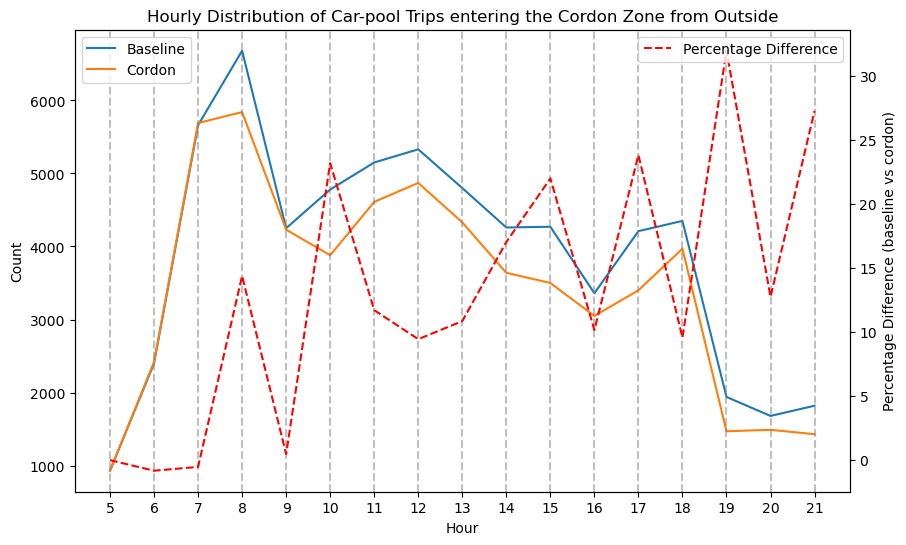

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = plans_carpool_to_save_base
# df1 = df1.drop(columns=df1.columns[-1])
df2 = plans_carpool_to_save_cordon
# df2 = df2.drop(columns=df2.columns[-1])

df1 = df1[~df1['ZIPo'].isin(cordon_zones)]
df1 = df1[df1['ZIP'].isin(cordon_zones)]
df2 = df2[~df2['ZIPo'].isin(cordon_zones)]
df2 = df2[df2['ZIP'].isin(cordon_zones)]

df1 = df1[df1['legDepartureTime']>=5*3600]
df2 = df2[df2['legDepartureTime']>=5*3600]

df1['legDepartureTime'] = pd.to_datetime(df1['legDepartureTime'], unit='s')
df1['hour'] = df1['legDepartureTime'].dt.hour
df1 = df1[df1['hour']>=5]
df1 = df1[df1['hour']<=21]
hourly_counts = df1['hour'].value_counts().sort_index() * 10

df2['legDepartureTime'] = pd.to_datetime(df2['legDepartureTime'], unit='s')
df2['hour'] = df2['legDepartureTime'].dt.hour
df2 = df2[df2['hour']>=5]
df2 = df2[df2['hour']<=21]
hourly_counts2 = df2['hour'].value_counts().sort_index() * 10

# Calculate percentage difference
percentage_diff = (hourly_counts - hourly_counts2) / hourly_counts2 * 100

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the hourly distribution from the first DataFrame (df1)
ax1.plot(hourly_counts.index, hourly_counts.values, label='Baseline')

# Plot the hourly distribution from the second DataFrame (df2)
ax1.plot(hourly_counts2.index, hourly_counts2.values, label='Cordon')

ax1.set_xlabel('Hour')
ax1.set_ylabel('Count')
ax1.set_title('Hourly Distribution of Car-pool Trips entering the Cordon Zone from Outside')

# Set x-axis ticks
plt.xticks(range(5, 22))

# Add vertical lines at every hour
for hour in range(5, 22):
    plt.axvline(x=hour, color='gray', linestyle='--', alpha=0.5)

# Add legend
ax1.legend(loc='upper left')

# Create a second y-axis on the right side
ax2 = ax1.twinx()
ax2.plot(hourly_counts2.index, percentage_diff.values, color='red', linestyle='--', label='Percentage Difference')
ax2.set_ylabel('Percentage Difference (baseline vs cordon)')
# ax2.yaxis.set_label_coords(1.06, 0.2)  # Adjust the position of the right y-axis label

# Add legend for the right y-axis plot
ax2.legend(loc='upper right')

plt.show()

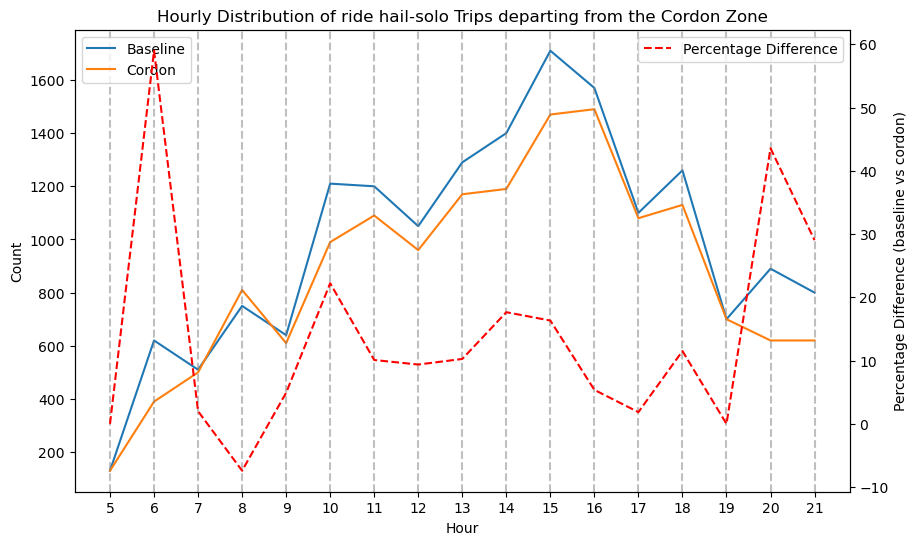

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = plans_rhsolo_to_save_base
df2 = plans_rhsolo_to_save_cordon

df1 = df1[df1['ZIPo'].isin(cordon_zones)]
# df1 = df1[df1['ZIP'].isin(cordon_zones)]
df2 = df2[df2['ZIPo'].isin(cordon_zones)]
# df2 = df2[df2['ZIP'].isin(cordon_zones)]

df1 = df1[df1['legDepartureTime']>=5*3600]
df2 = df2[df2['legDepartureTime']>=5*3600]

df1['legDepartureTime'] = pd.to_datetime(df1['legDepartureTime'], unit='s')
df1['hour'] = df1['legDepartureTime'].dt.hour
df1 = df1[df1['hour']>=5]
df1 = df1[df1['hour']<=21]
hourly_counts = df1['hour'].value_counts().sort_index() * 10

df2['legDepartureTime'] = pd.to_datetime(df2['legDepartureTime'], unit='s')
df2['hour'] = df2['legDepartureTime'].dt.hour
df2 = df2[df2['hour']>=5]
df2 = df2[df2['hour']<=21]
hourly_counts2 = df2['hour'].value_counts().sort_index() * 10

# Calculate percentage difference
percentage_diff = (hourly_counts - hourly_counts2) / hourly_counts2 * 100

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the hourly distribution from the first DataFrame (df1)
ax1.plot(hourly_counts.index, hourly_counts.values, label='Baseline')

# Plot the hourly distribution from the second DataFrame (df2)
ax1.plot(hourly_counts2.index, hourly_counts2.values, label='Cordon')

ax1.set_xlabel('Hour')
ax1.set_ylabel('Count')
ax1.set_title('Hourly Distribution of ride hail-solo Trips departing from the Cordon Zone')

# Set x-axis ticks
plt.xticks(range(5, 22))

# Add vertical lines at every hour
for hour in range(5, 22):
    plt.axvline(x=hour, color='gray', linestyle='--', alpha=0.5)

# Add legend
ax1.legend(loc='upper left')

# Create a second y-axis on the right side
ax2 = ax1.twinx()
ax2.plot(hourly_counts2.index, percentage_diff.values, color='red', linestyle='--', label='Percentage Difference')
ax2.set_ylabel('Percentage Difference (baseline vs cordon)')
# ax2.yaxis.set_label_coords(1.06, 0.2)  # Adjust the position of the right y-axis label

# Add legend for the right y-axis plot
ax2.legend(loc='upper right')

plt.show()

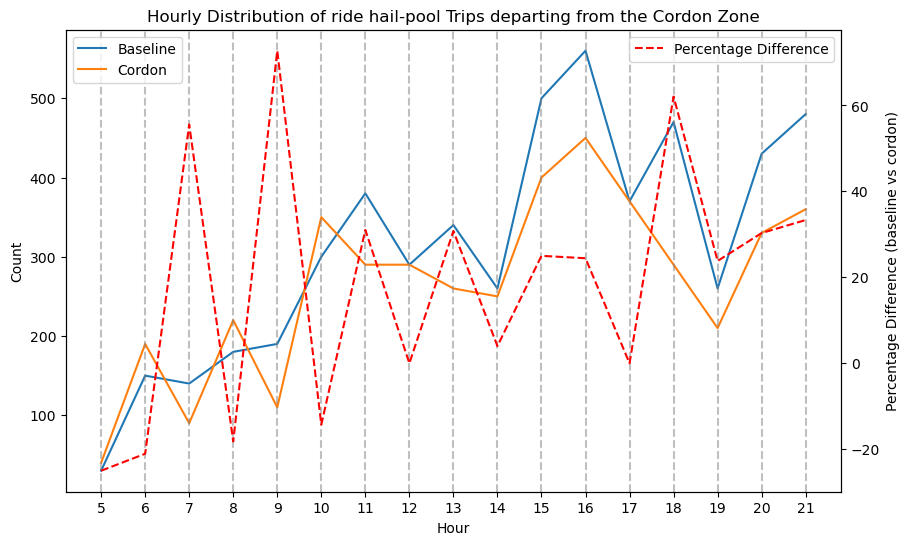

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = plans_rhpool_to_save_base
df2 = plans_rhpool_to_save_cordon

df1 = df1[df1['ZIPo'].isin(cordon_zones)]
# df1 = df1[df1['ZIP'].isin(cordon_zones)]
df2 = df2[df2['ZIPo'].isin(cordon_zones)]
# df2 = df2[df2['ZIP'].isin(cordon_zones)]

df1 = df1[df1['legDepartureTime']>=5*3600]
df2 = df2[df2['legDepartureTime']>=5*3600]

df1['legDepartureTime'] = pd.to_datetime(df1['legDepartureTime'], unit='s')
df1['hour'] = df1['legDepartureTime'].dt.hour
df1 = df1[df1['hour']>=5]
df1 = df1[df1['hour']<=21]
hourly_counts = df1['hour'].value_counts().sort_index() * 10

df2['legDepartureTime'] = pd.to_datetime(df2['legDepartureTime'], unit='s')
df2['hour'] = df2['legDepartureTime'].dt.hour
df2 = df2[df2['hour']>=5]
df2 = df2[df2['hour']<=21]
hourly_counts2 = df2['hour'].value_counts().sort_index() * 10

# Calculate percentage difference
percentage_diff = (hourly_counts - hourly_counts2) / hourly_counts2 * 100

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the hourly distribution from the first DataFrame (df1)
ax1.plot(hourly_counts.index, hourly_counts.values, label='Baseline')

# Plot the hourly distribution from the second DataFrame (df2)
ax1.plot(hourly_counts2.index, hourly_counts2.values, label='Cordon')

ax1.set_xlabel('Hour')
ax1.set_ylabel('Count')
ax1.set_title('Hourly Distribution of ride hail-pool Trips departing from the Cordon Zone')

# Set x-axis ticks
plt.xticks(range(5, 22))

# Add vertical lines at every hour
for hour in range(5, 22):
    plt.axvline(x=hour, color='gray', linestyle='--', alpha=0.5)

# Add legend
ax1.legend(loc='upper left')

# Create a second y-axis on the right side
ax2 = ax1.twinx()
ax2.plot(hourly_counts2.index, percentage_diff.values, color='red', linestyle='--', label='Percentage Difference')
ax2.set_ylabel('Percentage Difference (baseline vs cordon)')
# ax2.yaxis.set_label_coords(1.06, 0.2)  # Adjust the position of the right y-axis label

# Add legend for the right y-axis plot
ax2.legend(loc='upper right')

plt.show()

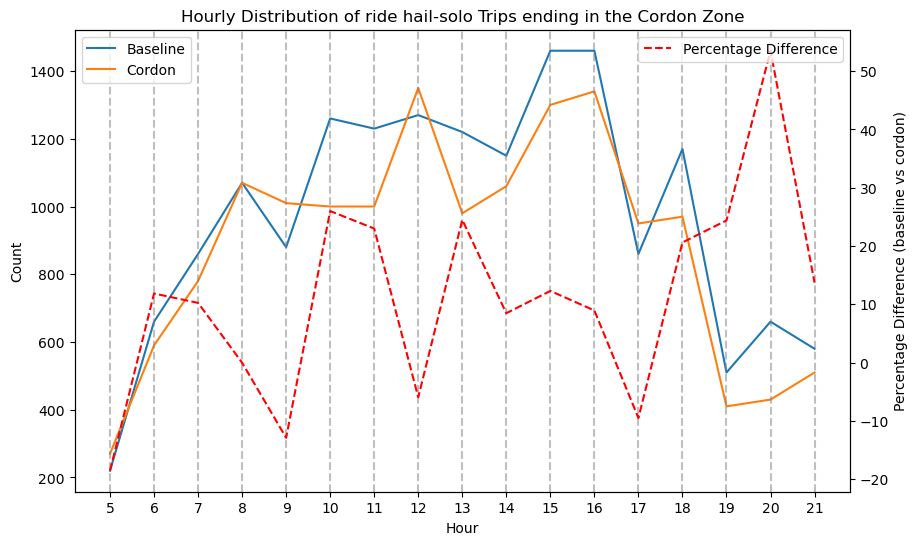

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = plans_rhsolo_to_save_base
df2 = plans_rhsolo_to_save_cordon

# df1 = df1[~df1['ZIPo'].isin(cordon_zones)]
df1 = df1[df1['ZIP'].isin(cordon_zones)]
# df2 = df2[~df2['ZIPo'].isin(cordon_zones)]
df2 = df2[df2['ZIP'].isin(cordon_zones)]

df1 = df1[df1['legDepartureTime']>=5*3600]
df2 = df2[df2['legDepartureTime']>=5*3600]

df1['legDepartureTime'] = pd.to_datetime(df1['legDepartureTime'], unit='s')
df1['hour'] = df1['legDepartureTime'].dt.hour
df1 = df1[df1['hour']>=5]
df1 = df1[df1['hour']<=21]
hourly_counts = df1['hour'].value_counts().sort_index() * 10

df2['legDepartureTime'] = pd.to_datetime(df2['legDepartureTime'], unit='s')
df2['hour'] = df2['legDepartureTime'].dt.hour
df2 = df2[df2['hour']>=5]
df2 = df2[df2['hour']<=21]
hourly_counts2 = df2['hour'].value_counts().sort_index() * 10

# Calculate percentage difference
percentage_diff = (hourly_counts - hourly_counts2) / hourly_counts2 * 100

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the hourly distribution from the first DataFrame (df1)
ax1.plot(hourly_counts.index, hourly_counts.values, label='Baseline')

# Plot the hourly distribution from the second DataFrame (df2)
ax1.plot(hourly_counts2.index, hourly_counts2.values, label='Cordon')

ax1.set_xlabel('Hour')
ax1.set_ylabel('Count')
ax1.set_title('Hourly Distribution of ride hail-solo Trips ending in the Cordon Zone')

# Set x-axis ticks
plt.xticks(range(5, 22))

# Add vertical lines at every hour
for hour in range(5, 22):
    plt.axvline(x=hour, color='gray', linestyle='--', alpha=0.5)

# Add legend
ax1.legend(loc='upper left')

# Create a second y-axis on the right side
ax2 = ax1.twinx()
ax2.plot(hourly_counts2.index, percentage_diff.values, color='red', linestyle='--', label='Percentage Difference')
ax2.set_ylabel('Percentage Difference (baseline vs cordon)')
# ax2.yaxis.set_label_coords(1.06, 0.2)  # Adjust the position of the right y-axis label

# Add legend for the right y-axis plot
ax2.legend(loc='upper right')

plt.show()

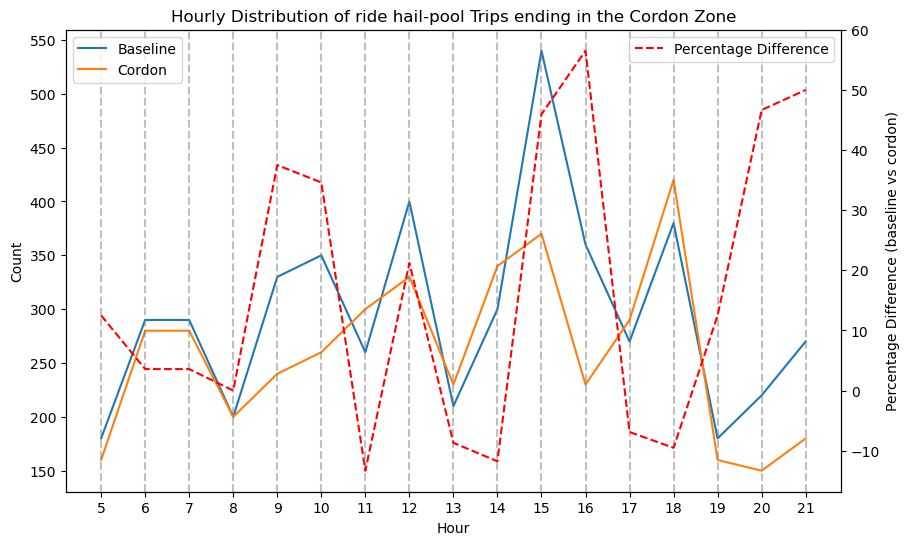

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = plans_rhpool_to_save_base
df2 = plans_rhpool_to_save_cordon

# df1 = df1[~df1['ZIPo'].isin(cordon_zones)]
df1 = df1[df1['ZIP'].isin(cordon_zones)]
# df2 = df2[~df2['ZIPo'].isin(cordon_zones)]
df2 = df2[df2['ZIP'].isin(cordon_zones)]

df1 = df1[df1['legDepartureTime']>=5*3600]
df2 = df2[df2['legDepartureTime']>=5*3600]

df1['legDepartureTime'] = pd.to_datetime(df1['legDepartureTime'], unit='s')
df1['hour'] = df1['legDepartureTime'].dt.hour
df1 = df1[df1['hour']>=5]
df1 = df1[df1['hour']<=21]
hourly_counts = df1['hour'].value_counts().sort_index() * 10

df2['legDepartureTime'] = pd.to_datetime(df2['legDepartureTime'], unit='s')
df2['hour'] = df2['legDepartureTime'].dt.hour
df2 = df2[df2['hour']>=5]
df2 = df2[df2['hour']<=21]
hourly_counts2 = df2['hour'].value_counts().sort_index() * 10

# Calculate percentage difference
percentage_diff = (hourly_counts - hourly_counts2) / hourly_counts2 * 100

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the hourly distribution from the first DataFrame (df1)
ax1.plot(hourly_counts.index, hourly_counts.values, label='Baseline')

# Plot the hourly distribution from the second DataFrame (df2)
ax1.plot(hourly_counts2.index, hourly_counts2.values, label='Cordon')

ax1.set_xlabel('Hour')
ax1.set_ylabel('Count')
ax1.set_title('Hourly Distribution of ride hail-pool Trips ending in the Cordon Zone')

# Set x-axis ticks
plt.xticks(range(5, 22))

# Add vertical lines at every hour
for hour in range(5, 22):
    plt.axvline(x=hour, color='gray', linestyle='--', alpha=0.5)

# Add legend
ax1.legend(loc='upper left')

# Create a second y-axis on the right side
ax2 = ax1.twinx()
ax2.plot(hourly_counts2.index, percentage_diff.values, color='red', linestyle='--', label='Percentage Difference')
ax2.set_ylabel('Percentage Difference (baseline vs cordon)')
# ax2.yaxis.set_label_coords(1.06, 0.2)  # Adjust the position of the right y-axis label

# Add legend for the right y-axis plot
ax2.legend(loc='upper right')

plt.show()

In [15]:
max(hourly_counts)/np.mean(hourly_counts)


1.8250497017892644

In [16]:
max(hourly_counts2)/np.mean(hourly_counts2)

1.6153846153846154

In [17]:
(max(hourly_counts)/np.mean(hourly_counts)-max(hourly_counts2)/np.mean(hourly_counts2))/(max(hourly_counts2)/np.mean(hourly_counts2))*100

12.979267253621126

In [18]:
scale = 1
scale2 = 1

in_zone = 0
out_zone = 0
for zone, count  in zip(distr_car_base.index,distr_car_base['Number_car_trips_arriving']):
    if zone in cordon_zones:
        in_zone += count
    else:
        out_zone += count
print('BASELINE - Car Destination inside the zone:', in_zone*scale, '; Car Destination outside the zone:', out_zone*scale )
in_zone_car_dest_base = in_zone
out_zone_car_dest_base = out_zone

in_zone = 0
out_zone = 0
for zone, count  in zip(distr_car_cordon.index,distr_car_cordon['Number_car_trips_arriving']):
    if zone in cordon_zones:
        in_zone += count
    else:
        out_zone += count
print('CORDON - Car Destination inside the zone:', in_zone*scale2, '; Car Destination outside the zone:', out_zone*scale2 )
in_zone_car_dest_cordon = in_zone
out_zone_car_dest_cordon = out_zone

print('Percentage Diff - Car Destination inside the zone:', (in_zone_car_dest_cordon*scale2 -in_zone_car_dest_base*scale)/in_zone_car_dest_base*scale*100,'%') 
print('Percentage Diff - Car Destination outside the zone:', (out_zone_car_dest_cordon*scale2 -out_zone_car_dest_base*scale)/out_zone_car_dest_base*scale*100,'%')

in_zone = 0
out_zone = 0
for zone, count  in zip(distr_rh_base_dest.index,distr_rh_base_dest['Number_rh_trips_arriving']):
    if zone in cordon_zones:
        in_zone += count
    else:
        out_zone += count
print('BASELINE - RH Destination inside the zone:', in_zone*scale, '; RH Destination outside the zone:', out_zone*scale )
in_zone_rh_dest_base = in_zone
out_zone_rh_dest_base = out_zone

in_zone = 0
out_zone = 0
for zone, count  in zip(distr_rh_cordon_dest.index,distr_rh_cordon_dest['Number_rh_trips_arriving']):
    if zone in cordon_zones:
        in_zone += count
    else:
        out_zone += count
print('CORDON - RH Destination inside the zone:', in_zone*scale2, '; RH Destination outside the zone:', out_zone*scale2 )
in_zone_rh_dest_cordon = in_zone
out_zone_rh_dest_cordon = out_zone

print('Percentage Diff - RH Destination inside the zone:', (in_zone_rh_dest_cordon*scale2 -in_zone_rh_dest_base*scale)/in_zone_rh_dest_base*scale*100,'%') 
print('Percentage Diff - RH Destination outside the zone:', (out_zone_rh_dest_cordon*scale2 -out_zone_rh_dest_base*scale)/out_zone_rh_dest_base*scale*100,'%')

in_zone = 0
out_zone = 0
for zone, count  in zip(distr_rh_base_orig.index,distr_rh_base_orig['Number_rh_trips_departing']):
    if zone in cordon_zones:
        in_zone += count
    else:
        out_zone += count
print('BASELINE - RH Origin inside the zone:', in_zone*scale, '; RH Origin outside the zone:', out_zone*scale )
in_zone_rh_orig_base = in_zone
out_zone_rh_orig_base = out_zone

in_zone = 0
out_zone = 0
for zone, count  in zip(distr_rh_cordon_orig.index,distr_rh_cordon_orig['Number_rh_trips_departing']):
    if zone in cordon_zones:
        in_zone += count
    else:
        out_zone += count
print('CORDON - RH Origin inside the zone:', in_zone*scale2, '; RH Origin outside the zone:', out_zone*scale2 )
in_zone_rh_orig_cordon = in_zone
out_zone_rh_orig_cordon = out_zone

print('Percentage Diff - RH Origin inside the zone:', (in_zone_rh_orig_cordon*scale2 -in_zone_rh_orig_base*scale)/in_zone_rh_orig_base*scale*100,'%') 
print('Percentage Diff - RH Origin outside the zone:', (out_zone_rh_orig_cordon*scale2 -out_zone_rh_orig_base*scale)/out_zone_rh_orig_base*scale*100,'%')




in_zone = 0
out_zone = 0
for zone, count  in zip(distr_car_base_peak.index,distr_car_base_peak['Number_car_trips_arriving']):
    if zone in cordon_zones:
        in_zone += count
    else:
        out_zone += count
print('BASELINE PEAK HOURS - Car Destination inside the zone:', in_zone*scale, '; Car Destination outside the zone:', out_zone*scale )
in_zone_car_dest_base_peak = in_zone
out_zone_car_dest_base_peak = out_zone

in_zone = 0
out_zone = 0
for zone, count  in zip(distr_car_cordon_peak.index,distr_car_cordon_peak['Number_car_trips_arriving']):
    if zone in cordon_zones:
        in_zone += count
    else:
        out_zone += count
print('CORDON PEAK HOURS - Car Destination inside the zone:', in_zone*scale2, '; Car Destination outside the zone:', out_zone*scale2 )
in_zone_car_dest_cordon_peak = in_zone
out_zone_car_dest_cordon_peak = out_zone

print('PEAK HOURS - Percentage Diff - Car Destination inside the zone:', (in_zone_car_dest_cordon_peak*scale2 -in_zone_car_dest_base_peak*scale)/in_zone_car_dest_base_peak*scale*100,'%') 
print('PEAK HOURS - Percentage Diff - Car Destination outside the zone:', (out_zone_car_dest_cordon_peak*scale2 -out_zone_car_dest_base_peak*scale)/out_zone_car_dest_base_peak*scale*100,'%')

in_zone = 0
out_zone = 0
for zone, count  in zip(distr_rh_base_dest_peak.index,distr_rh_base_dest_peak['Number_rh_trips_arriving']):
    if zone in cordon_zones:
        in_zone += count
    else:
        out_zone += count
print('BASELINE PEAK HOURS - RH Destination inside the zone:', in_zone*scale, '; RH Destination outside the zone:', out_zone*scale )
in_zone_rh_dest_base_peak = in_zone
out_zone_rh_dest_base_peak = out_zone

in_zone = 0
out_zone = 0
for zone, count  in zip(distr_rh_cordon_dest_peak.index,distr_rh_cordon_dest_peak['Number_rh_trips_arriving']):
    if zone in cordon_zones:
        in_zone += count
    else:
        out_zone += count
print('CORDON PEAK HOURS - RH Destination inside the zone:', in_zone*scale2, '; RH Destination outside the zone:', out_zone*scale2 )
in_zone_rh_dest_cordon_peak = in_zone
out_zone_rh_dest_cordon_peak = out_zone

print('PEAK HOURS - Percentage Diff - RH Destination inside the zone:', (in_zone_rh_dest_cordon_peak*scale2 -in_zone_rh_dest_base_peak*scale)/in_zone_rh_dest_base_peak*scale*100,'%') 
print('PEAK HOURS - Percentage Diff - RH Destination outside the zone:', (out_zone_rh_dest_cordon_peak*scale2 -out_zone_rh_dest_base_peak*scale)/out_zone_rh_dest_base_peak*scale*100,'%')

in_zone = 0
out_zone = 0
for zone, count  in zip(distr_rh_base_orig_peak.index,distr_rh_base_orig_peak['Number_rh_trips_departing']):
    if zone in cordon_zones:
        in_zone += count
    else:
        out_zone += count
print('BASELINE PEAK HOURS - RH Origin inside the zone:', in_zone*scale, '; RH Origin outside the zone:', out_zone*scale )
in_zone_rh_orig_base_peak = in_zone
out_zone_rh_orig_base_peak = out_zone

in_zone = 0
out_zone = 0
for zone, count  in zip(distr_rh_cordon_orig_peak.index,distr_rh_cordon_orig_peak['Number_rh_trips_departing']):
    if zone in cordon_zones:
        in_zone += count
    else:
        out_zone += count
print('CORDON PEAK HOURS - RH Origin inside the zone:', in_zone*scale2, '; RH Origin outside the zone:', out_zone*scale2 )
in_zone_rh_orig_cordon_peak = in_zone
out_zone_rh_orig_cordon_peak = out_zone

print('PEAK HOURS - Percentage Diff - RH Origin inside the zone:', (in_zone_rh_orig_cordon_peak*scale2 -in_zone_rh_orig_base_peak*scale)/in_zone_rh_orig_base_peak*scale*100,'%') 
print('PEAK HOURS - Percentage Diff - RH Origin outside the zone:', (out_zone_rh_orig_cordon_peak*scale2 -out_zone_rh_orig_base_peak*scale)/out_zone_rh_orig_base_peak*scale*100,'%')

print('BASELINE OUTSIDE PEAK - Car Destination inside the zone:', (in_zone_car_dest_base-in_zone_car_dest_base_peak)*scale, '; Car Destination outside the zone:', (out_zone_car_dest_base-out_zone_car_dest_base_peak)*scale )
print('CORDON OUTSIDE PEAK - Car Destination inside the zone:', (in_zone_car_dest_cordon-in_zone_car_dest_cordon_peak)*scale2, '; Car Destination outside the zone:', (out_zone_car_dest_cordon-out_zone_car_dest_cordon_peak)*scale2 )
print('OUTSIDE PEAK - Percentage Diff - Car Destination inside the zone:', ((in_zone_car_dest_cordon-in_zone_car_dest_cordon_peak)*scale2 -(in_zone_car_dest_base-in_zone_car_dest_base_peak)*scale)/(in_zone_car_dest_base-in_zone_car_dest_base_peak)*scale*100,'%') 
print('OUTSIDE PEAK - Percentage Diff - Car Destination outside the zone:', ((out_zone_car_dest_cordon-out_zone_car_dest_cordon_peak)*scale2 -(out_zone_car_dest_base-out_zone_car_dest_base_peak)*scale)/(out_zone_car_dest_base-out_zone_car_dest_base_peak)*scale*100,'%')
print('BASELINE OUTSIDE PEAK - RH Destination inside the zone:', (in_zone_rh_dest_base-in_zone_rh_dest_base_peak)*scale, '; RH Destination outside the zone:', (out_zone_rh_dest_base-out_zone_rh_dest_base_peak)*scale )
print('CORDON OUTSIDE PEAK - RH Destination inside the zone:', (in_zone_rh_dest_cordon-in_zone_rh_dest_cordon_peak)*scale2, '; RH Destination outside the zone:', (out_zone_rh_dest_cordon-out_zone_rh_dest_cordon_peak)*scale2 )
print('OUTSIDE PEAK - Percentage Diff - RH Destination inside the zone:', ((in_zone_rh_dest_cordon-in_zone_rh_dest_cordon_peak)*scale2 -(in_zone_rh_dest_base-in_zone_rh_dest_base_peak)*scale)/(in_zone_rh_dest_base-in_zone_rh_dest_base_peak)*scale*100,'%') 
print('OUTSIDE PEAK - Percentage Diff - RH Destination outside the zone:', ((out_zone_rh_dest_cordon-out_zone_rh_dest_cordon_peak)*scale2 -(out_zone_rh_dest_base-out_zone_rh_dest_base_peak)*scale)/(out_zone_rh_dest_base-out_zone_rh_dest_base_peak)*scale*100,'%')
print('BASELINE OUTSIDE PEAK - RH Origin inside the zone:', (in_zone_rh_orig_base-in_zone_rh_orig_base_peak)*scale, '; RH Origin outside the zone:', (out_zone_rh_orig_base-out_zone_rh_orig_base_peak)*scale )
print('CORDON OUTSIDE PEAK - RH Origin inside the zone:', (in_zone_rh_orig_cordon-in_zone_rh_orig_cordon_peak)*scale2, '; RH Origin outside the zone:', (out_zone_rh_orig_cordon-out_zone_rh_orig_cordon_peak)*scale2 )
print('OUTSIDE PEAK - Percentage Diff - RH Origin inside the zone:', ((in_zone_rh_orig_cordon-in_zone_rh_orig_cordon_peak)*scale2 -(in_zone_rh_orig_base-in_zone_rh_orig_base_peak)*scale)/(in_zone_rh_orig_base-in_zone_rh_orig_base_peak)*scale*100,'%') 
print('OUTSIDE PEAK - Percentage Diff - RH Origin outside the zone:', ((out_zone_rh_orig_cordon-out_zone_rh_orig_cordon_peak)*scale2 -(out_zone_rh_orig_base-out_zone_rh_orig_base_peak)*scale)/(out_zone_rh_orig_base-out_zone_rh_orig_base_peak)*scale*100,'%')




in_zone = 0
out_zone = 0
for zone, count  in zip(distr_car_base_low_income.index,distr_car_base_low_income['Number_car_trips_arriving']):
    if zone in cordon_zones:
        in_zone += count
    else:
        out_zone += count
print('BASELINE LOW INCOME - Car Destination inside the zone:', in_zone*scale, '; Car Destination outside the zone:', out_zone*scale )
in_zone_car_dest_base_low_income = in_zone
out_zone_car_dest_base_low_income = out_zone

in_zone = 0
out_zone = 0
for zone, count  in zip(distr_car_cordon_low_income.index,distr_car_cordon_low_income['Number_car_trips_arriving']):
    if zone in cordon_zones:
        in_zone += count
    else:
        out_zone += count
print('CORDON LOW INCOME - Car Destination inside the zone:', in_zone*scale2, '; Car Destination outside the zone:', out_zone*scale2 )
in_zone_car_dest_cordon_low_income = in_zone
out_zone_car_dest_cordon_low_income = out_zone

print('LOW INCOME - Percentage Diff - Car Destination inside the zone:', (in_zone_car_dest_cordon_low_income*scale2 -in_zone_car_dest_base_low_income*scale)/in_zone_car_dest_base_low_income*scale*100,'%') 
print('LOW INCOME - Percentage Diff - Car Destination outside the zone:', (out_zone_car_dest_cordon_low_income*scale2 -out_zone_car_dest_base_low_income*scale)/out_zone_car_dest_base_low_income*scale*100,'%')

in_zone = 0
out_zone = 0
for zone, count  in zip(distr_rh_base_dest_low_income.index,distr_rh_base_dest_low_income['Number_rh_trips_arriving']):
    if zone in cordon_zones:
        in_zone += count
    else:
        out_zone += count
print('BASELINE LOW INCOME - RH Destination inside the zone:', in_zone*scale, '; RH Destination outside the zone:', out_zone*scale )
in_zone_rh_dest_base_low_income = in_zone
out_zone_rh_dest_base_low_income = out_zone

in_zone = 0
out_zone = 0
for zone, count  in zip(distr_rh_cordon_dest_low_income.index,distr_rh_cordon_dest_low_income['Number_rh_trips_arriving']):
    if zone in cordon_zones:
        in_zone += count
    else:
        out_zone += count
print('CORDON LOW INCOME - RH Destination inside the zone:', in_zone*scale2, '; RH Destination outside the zone:', out_zone*scale2 )
in_zone_rh_dest_cordon_low_income = in_zone
out_zone_rh_dest_cordon_low_income = out_zone

print('LOW INCOME - Percentage Diff - RH Destination inside the zone:', (in_zone_rh_dest_cordon_low_income*scale2 -in_zone_rh_dest_base_low_income*scale)/in_zone_rh_dest_base_low_income*scale*100,'%') 
print('LOW INCOME - Percentage Diff - RH Destination outside the zone:', (out_zone_rh_dest_cordon_low_income*scale2 -out_zone_rh_dest_base_low_income*scale)/out_zone_rh_dest_base_low_income*scale*100,'%')

in_zone = 0
out_zone = 0
for zone, count  in zip(distr_rh_base_orig_low_income.index,distr_rh_base_orig_low_income['Number_rh_trips_departing']):
    if zone in cordon_zones:
        in_zone += count
    else:
        out_zone += count
print('BASELINE LOW INCOME - RH Origin inside the zone:', in_zone*scale, '; RH Origin outside the zone:', out_zone*scale )
in_zone_rh_orig_base_low_income = in_zone
out_zone_rh_orig_base_low_income = out_zone

in_zone = 0
out_zone = 0
for zone, count  in zip(distr_rh_cordon_orig_low_income.index,distr_rh_cordon_orig_low_income['Number_rh_trips_departing']):
    if zone in cordon_zones:
        in_zone += count
    else:
        out_zone += count
print('CORDON LOW INCOME - RH Origin inside the zone:', in_zone*scale2, '; RH Origin outside the zone:', out_zone*scale2 )
in_zone_rh_orig_cordon_low_income = in_zone
out_zone_rh_orig_cordon_low_income = out_zone

print('LOW INCOME - Percentage Diff - RH Origin inside the zone:', (in_zone_rh_orig_cordon_low_income*scale2 -in_zone_rh_orig_base_low_income*scale)/in_zone_rh_orig_base_low_income*scale*scale*100,'%') 
print('LOW INCOME - Percentage Diff - RH Origin outside the zone:', (out_zone_rh_orig_cordon_low_income*scale2 -out_zone_rh_orig_base_low_income*scale)/out_zone_rh_orig_base_low_income*scale*scale*100,'%')


print('BASELINE HIGH INCOME - Car Destination inside the zone:', (in_zone_car_dest_base-in_zone_car_dest_base_low_income)*scale, '; Car Destination outside the zone:', (out_zone_car_dest_base-out_zone_car_dest_base_low_income)*scale )
print('CORDON HIGH INCOME - Car Destination inside the zone:', (in_zone_car_dest_cordon-in_zone_car_dest_cordon_low_income)*scale2, '; Car Destination outside the zone:', (out_zone_car_dest_cordon-out_zone_car_dest_cordon_low_income)*scale2 )
print('HIGH INCOME - Percentage Diff - Car Destination inside the zone:', ((in_zone_car_dest_cordon-in_zone_car_dest_cordon_low_income)*scale2 -(in_zone_car_dest_base-in_zone_car_dest_base_low_income)*scale)/(in_zone_car_dest_base-in_zone_car_dest_base_low_income)*scale*100,'%') 
print('HIGH INCOME - Percentage Diff - Car Destination outside the zone:', ((out_zone_car_dest_cordon-out_zone_car_dest_cordon_low_income)*scale2 -(out_zone_car_dest_base-out_zone_car_dest_base_low_income)*scale)/(out_zone_car_dest_base-out_zone_car_dest_base_low_income)*scale*100,'%')
print('BASELINE HIGH INCOME - RH Destination inside the zone:', (in_zone_rh_dest_base-in_zone_rh_dest_base_low_income)*scale, '; RH Destination outside the zone:', (out_zone_rh_dest_base-out_zone_rh_dest_base_low_income)*scale )
print('CORDON HIGH INCOME - RH Destination inside the zone:', (in_zone_rh_dest_cordon-in_zone_rh_dest_cordon_low_income)*scale2, '; RH Destination outside the zone:', (out_zone_rh_dest_cordon-out_zone_rh_dest_cordon_low_income)*scale2 )
print('HIGH INCOME - Percentage Diff - RH Destination inside the zone:', ((in_zone_rh_dest_cordon-in_zone_rh_dest_cordon_low_income)*scale2 -(in_zone_rh_dest_base-in_zone_rh_dest_base_low_income)*scale)/(in_zone_rh_dest_base-in_zone_rh_dest_base_low_income)*scale*100,'%') 
print('HIGH INCOME - Percentage Diff - RH Destination outside the zone:', ((out_zone_rh_dest_cordon-out_zone_rh_dest_cordon_low_income)*scale2 -(out_zone_rh_dest_base-out_zone_rh_dest_base_low_income)*scale)/(out_zone_rh_dest_base-out_zone_rh_dest_base_low_income)*scale*100,'%')
print('BASELINE HIGH INCOME - RH Origin inside the zone:', (in_zone_rh_orig_base-in_zone_rh_orig_base_low_income)*scale, '; RH Origin outside the zone:', (out_zone_rh_orig_base-out_zone_rh_orig_base_low_income)*scale )
print('CORDON HIGH INCOME - RH Origin inside the zone:', (in_zone_rh_orig_cordon-in_zone_rh_orig_cordon_low_income)*scale2, '; RH Origin outside the zone:', (out_zone_rh_orig_cordon-out_zone_rh_orig_cordon_low_income)*scale2 )
print('HIGH INCOME - Percentage Diff - RH Origin inside the zone:', ((in_zone_rh_orig_cordon-in_zone_rh_orig_cordon_low_income)*scale2 -(in_zone_rh_orig_base-in_zone_rh_orig_base_low_income)*scale)/(in_zone_rh_orig_base-in_zone_rh_orig_base_low_income)*scale*100,'%') 
print('HIGH INCOME - Percentage Diff - RH Origin outside the zone:', ((out_zone_rh_orig_cordon-out_zone_rh_orig_cordon_low_income)*scale2 -(out_zone_rh_orig_base-out_zone_rh_orig_base_low_income)*scale)/(out_zone_rh_orig_base-out_zone_rh_orig_base_low_income)*scale*100,'%')




BASELINE - Car Destination inside the zone: 19934 ; Car Destination outside the zone: 1150665
CORDON - Car Destination inside the zone: 16705 ; Car Destination outside the zone: 1151182
Percentage Diff - Car Destination inside the zone: -16.19845490117387 %
Percentage Diff - Car Destination outside the zone: 0.044930540165904066 %
BASELINE - RH Destination inside the zone: 2186 ; RH Destination outside the zone: 51181
CORDON - RH Destination inside the zone: 1974 ; RH Destination outside the zone: 51281
Percentage Diff - RH Destination inside the zone: -9.69807868252516 %
Percentage Diff - RH Destination outside the zone: 0.19538500615462767 %
BASELINE - RH Origin inside the zone: 2263 ; RH Origin outside the zone: 51105
CORDON - RH Origin inside the zone: 2002 ; RH Origin outside the zone: 51252
Percentage Diff - RH Origin inside the zone: -11.533362792752982 %
Percentage Diff - RH Origin outside the zone: 0.28764308776049313 %
BASELINE PEAK HOURS - Car Destination inside the zone: 11

In [19]:
#check income
#check beam route costs
#check peak

# Network for BEAM

In [20]:

def addGeometryIdToDataFrame(df, gdf, xcol, ycol, idColumn="geometry", df_geom='epsg:32610'): 
    gdf.crs = {'init': 'epsg:4326'}
    gdf_data = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[xcol], df[ycol]))
    gdf_data.crs = {'init': df_geom}
    joined = gpd.sjoin(gdf_data.to_crs('epsg:26910'), gdf.to_crs('epsg:26910'))
    gdf_data = gdf_data.merge(joined['zone_id'], left_index=True, right_index=True, how="left")
    gdf_data.rename(columns={'zone_id': idColumn}, inplace=True)
    df = pd.DataFrame(gdf_data.drop(columns='geometry'))
    # df.drop(columns=[xcol, ycol], inplace=True)
    
    return df.loc[~df.index.duplicated(keep='first'), :]

In [21]:
network

NameError: name 'network' is not defined

In [ ]:
network =     pd.read_csv('gs://beam-core-outputs/sfbay-baseline-20230526/beam/year-2020-iteration-4/network.csv.gz')


In [ ]:
TAZs = gpd.read_file('inputs/taz_sfbay.shp')
cordon_tazs = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', 
                '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', 
                '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', 
                '40', '41', '79', '109', '110']




In [ ]:
network = addGeometryIdToDataFrame(network, TAZs, 'fromLocationX', 'fromLocationY', 'TAZ_Origin')
network = addGeometryIdToDataFrame(network, TAZs, 'toLocationX', 'toLocationY', 'TAZ_Destination')

In [ ]:
toll_links = []
for orig, dest, link in zip(network['TAZ_Origin'],network['TAZ_Destination'],network['linkId']):
    if dest in cordon_tazs and orig not in cordon_tazs:
        toll_links.append(1)
    else:
        toll_links.append(0)
network['is_toll'] = toll_links
network = network.dropna(axis=0)
network_toll = network[network['is_toll']==1]

In [ ]:
network_toll.to_csv('outputs/network_tolls.csv')

In [ ]:
TAZs2 = gpd.read_file('inputs/taz_sfbay2.shp')


In [ ]:
list(TAZs2.zone_id)

# Check BEAM Toll

In [ ]:
linkstat_base =     pd.read_csv('gs://beam-core-outputs/sfbay-baseline-20230526/beam/year-2020-iteration-4/ITERS/it.0/0.events.csv.gz', nrows = 13300000)
# linkstat_cordon =     pd.read_csv('gs://beam-core-outputs/sfbay-cordon-test2-20230626/beam/year-2020-iteration-4/ITERS/it.0/0.linkstats.csv.gz')


In [ ]:
linkstat_base.keys()

In [ ]:
linkstat_base_cost = linkstat_base[linkstat_base['type']=='PersonCost']

In [ ]:
linkstat_base_cost

In [ ]:
linkstat_base[linkstat_base['netCost']>0]['type']